In [1]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, DepthwiseConv2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
from matplotlib import gridspec 
plt.style.use('dark_background')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.InteractiveSession(config=config)
from datetime import datetime

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [5]:
data.shape

(42000, 785)

In [6]:
classWeight = class_weight.compute_class_weight(y=data.label, classes=np.unique(data.label), class_weight='balanced')
weights = dict(zip(np.unique(data.label),classWeight))

In [7]:
lb = LabelBinarizer()
lb.fit(data['label'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [8]:
data = data.join(pd.DataFrame(lb.transform(data['label']), columns=lb.classes_))
data.drop(columns=['label'], inplace=True)


In [9]:
data.shape

(42000, 794)

In [10]:
x_data = data.drop(columns=list(range(0,10))).values.reshape(-1,28,28)/255.

In [11]:
y_data = data[list(range(0,10))]

In [12]:
x_train, x_test, y_train, y_test =  train_test_split(x_data, y_data, test_size=0.1)

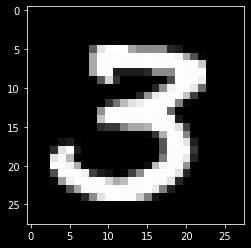

In [13]:
plt.imshow(np.array(x_train[10]), cmap='gray')

In [14]:
classifier = Sequential()
image_shape = (28, 28, 1)
workers = 10
epochs = 30

In [15]:
classifier = Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
    Conv2D(100, kernel_size=(2, 2), strides = 1, input_shape = image_shape, activation = 'relu', padding='same'),
    AveragePooling2D(pool_size = (2, 2), strides = 1),
#     Dropout(0.2),
    Conv2D(10, kernel_size=(2, 2), activation = 'relu', padding='same'),
    AveragePooling2D(pool_size = (5, 2), strides=1),
    Conv2D(10, kernel_size=(2, 2), activation = 'relu', padding='same'),
    AveragePooling2D(pool_size = (2, 5), strides=1),
#     Dropout(0.2),
    Conv2D(100, kernel_size=(2, 2), activation = 'relu', padding='same'),
    AveragePooling2D(pool_size = (2, 2), strides=1),
#     Dropout(0.02),
    Flatten(),
    Dense(units = 100, activation = 'relu'),
    Dense(units = 50, activation = 'relu'),
    Dense(units = 10, activation = 'sigmoid')])


In [16]:
classifier.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'], )

In [17]:
print(classifier.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 100)       500       
_________________________________________________________________
average_pooling2d (AveragePo (None, 27, 27, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 10)        4010      
_________________________________________________________________
average_pooling2d_1 (Average (None, 23, 26, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 26, 10)        410       
_________________________________________________________________
average_pooling2d_2 (Average (None, 22, 22, 10)       

In [18]:
checkpoint = ModelCheckpoint(filepath='digits_best.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)
reduce_learning = ReduceLROnPlateau(monitor='val_loss', 
                                    factor=0.2, 
                                    patience=2, 
                                    verbose=1, 
                                    min_lr=1e-5)

In [19]:
cnn = classifier.fit(x=x_train, y=y_train, class_weight=weights,
                     validation_split=0.05,
                     shuffle=True,
                     epochs=epochs,
                     use_multiprocessing=True,
                     workers=workers, 
                     callbacks=[checkpoint, reduce_learning])

Epoch 1/30
1123/1123 [==============================] - 11s 9ms/step - loss: 0.4541 - accuracy: 0.8540 - val_loss: 0.0897 - val_accuracy: 0.9741

Epoch 00001: val_loss improved from inf to 0.08967, saving model to digits_best.hdf5
Epoch 2/30
1123/1123 [==============================] - 10s 9ms/step - loss: 0.0828 - accuracy: 0.9736 - val_loss: 0.0723 - val_accuracy: 0.9772

Epoch 00002: val_loss improved from 0.08967 to 0.07231, saving model to digits_best.hdf5
Epoch 3/30
1123/1123 [==============================] - 10s 9ms/step - loss: 0.0592 - accuracy: 0.9819 - val_loss: 0.0677 - val_accuracy: 0.9831

Epoch 00003: val_loss improved from 0.07231 to 0.06774, saving model to digits_best.hdf5
Epoch 4/30
1123/1123 [==============================] - 10s 9ms/step - loss: 0.0406 - accuracy: 0.9868 - val_loss: 0.0532 - val_accuracy: 0.9831

Epoch 00004: val_loss improved from 0.06774 to 0.05319, saving model to digits_best.hdf5
Epoch 5/30
1123/1123 [==============================] - 10s 9ms/

In [20]:
classifier.load_weights('digits_best.hdf5')
classifier.save('digits_best.h5')
cnn_best = load_model('digits_best.h5')

<Figure size 1080x432 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'yield')

(0, 0.5)

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'yield')

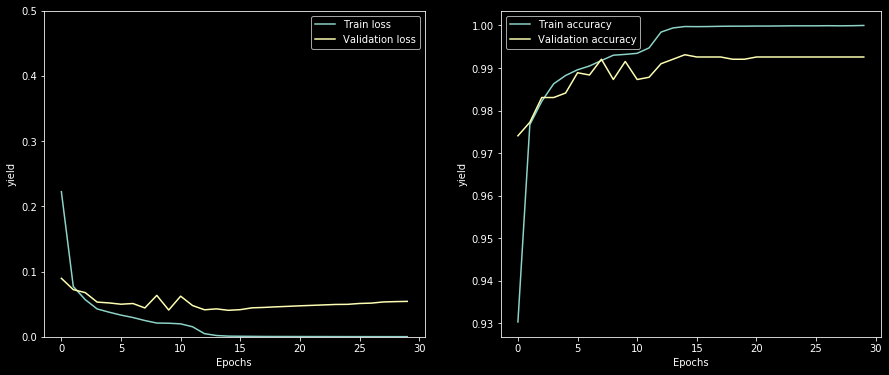

In [21]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(cnn.epoch, cnn.history["loss"], label="Train loss")
plt.plot(cnn.epoch, cnn.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("yield")
plt.ylim(0,0.5)
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn.epoch, cnn.history["accuracy"], label="Train accuracy")
plt.plot(cnn.epoch, cnn.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("yield")
plt.legend()

plt.show()

In [22]:
evaluation = cnn_best.evaluate(x=x_train, y=y_train,
                               steps=len(x_train),
                               verbose=1,
                               workers=10)

37800/37800 [==============================] - 48s 1ms/step - loss: 0.0028 - accuracy: 0.9994


In [23]:
pd.DataFrame(np.round(evaluation,2), cnn_best.metrics_names, columns=["model evaluation"])

model evaluation
loss                   0.0
accuracy               1.0

In [24]:
predictions = cnn_best.predict(x_test,
                               steps=len(x_test),
                               verbose=1, 
                               workers=10)

4200/4200 [==============================] - 4s 955us/step


In [25]:
y_test_true = lb.inverse_transform(np.asarray(y_test))
y_test_pred = predictions.argmax(1)
classes = [str(i) for i in range(0,10)]
print(classification_report(y_test_true, 
                      y_test_pred, 
                      target_names = classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       404
           1       1.00      1.00      1.00       481
           2       0.99      0.99      0.99       419
           3       1.00      0.99      0.99       439
           4       0.99      0.99      0.99       395
           5       0.99      0.99      0.99       389
           6       0.99      0.99      0.99       412
           7       0.99      0.99      0.99       450
           8       0.99      1.00      0.99       396
           9       1.00      0.99      0.99       415

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [26]:
cm_test = pd.DataFrame(confusion_matrix(y_test_true, y_test_pred), 
                       columns=classes, 
                       index=classes)
cm_test

0    1    2    3    4    5    6    7    8    9
0  403    0    0    0    0    0    0    0    1    0
1    0  479    0    0    1    0    0    0    1    0
2    2    0  414    0    0    0    0    2    1    0
3    0    0    1  434    0    2    0    0    2    0
4    0    0    0    0  393    0    1    0    0    1
5    0    0    0    2    0  386    1    0    0    0
6    4    0    0    0    0    1  407    0    0    0
7    0    1    2    0    0    0    1  445    0    1
8    0    0    0    0    0    1    0    0  395    0
9    2    0    0    0    1    1    0    1    0  410

<Figure size 864x648 with 0 Axes>

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

Text(87.0, 0.5, 'True')

Text(0.5, 60.0, 'Prediction')

(0, 10)

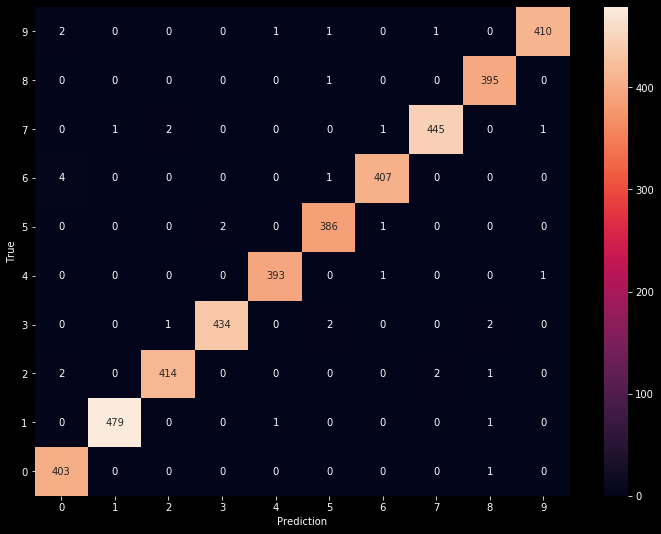

In [27]:
plt.figure(figsize=(12,9))
sns.heatmap(cm_test, annot=True, fmt='d',
            xticklabels=classes,
            yticklabels=classes)
plt.yticks(rotation=0)
plt.ylabel('True')
plt.xlabel('Prediction')
plt.ylim(0, 10)

In [28]:
cnn = classifier.fit(x=x_test, y=y_test,
                     validation_split=0.3,
                     shuffle=True,
                     epochs=epochs//2,
                     use_multiprocessing=True,
                     workers=workers, 
                     callbacks=[checkpoint])

Epoch 1/15
92/92 [==============================] - 1s 12ms/step - loss: 0.0520 - accuracy: 0.9922 - val_loss: 0.0311 - val_accuracy: 0.9921

Epoch 00001: val_loss improved from 0.04062 to 0.03109, saving model to digits_best.hdf5
Epoch 2/15
92/92 [==============================] - 1s 10ms/step - loss: 0.0421 - accuracy: 0.9922 - val_loss: 0.0321 - val_accuracy: 0.9929

Epoch 00002: val_loss did not improve from 0.03109
Epoch 3/15
92/92 [==============================] - 1s 10ms/step - loss: 0.0373 - accuracy: 0.9929 - val_loss: 0.0323 - val_accuracy: 0.9921

Epoch 00003: val_loss did not improve from 0.03109
Epoch 4/15
92/92 [==============================] - 1s 11ms/step - loss: 0.0337 - accuracy: 0.9935 - val_loss: 0.0321 - val_accuracy: 0.9921

Epoch 00004: val_loss did not improve from 0.03109
Epoch 5/15
92/92 [==============================] - 1s 10ms/step - loss: 0.0309 - accuracy: 0.9939 - val_loss: 0.0321 - val_accuracy: 0.9929

Epoch 00005: val_loss did not improve from 0.031

In [29]:
classifier.load_weights('digits_best.hdf5')
classifier.save('digits_best.h5')
cnn_best = load_model('digits_best.h5')

In [30]:
to_predict = pd.read_csv('test.csv').values.reshape(-1,28,28)/255.

In [31]:
sub_predictions = cnn_best.predict(to_predict,
                                   steps=len(to_predict),
                                   verbose=1, 
                                   workers=10)

28000/28000 [==============================] - 28s 985us/step


In [32]:
sub_predictions.argmax(1)

array([2, 0, 9, ..., 3, 9, 2])

In [33]:
to_submit = pd.DataFrame(data={'ImageId': list(range(1,28001)), 'Label': sub_predictions.argmax(1)})

In [34]:
timesstamp = datetime.now().strftime('%Y%m%d-%H%M%S')
to_submit.to_csv(f'submit_{timesstamp}.csv', index=False)